In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from   IPython.display import display, HTML
import pprint
import datetime
import matplotlib.dates as md
from pathlib import Path
import os
import math
from scipy.stats import poisson
from scipy import interpolate
from collections import deque
import matplotlib.dates as md
from IPython.display import clear_output
from scipy.interpolate import interpn
from scipy.interpolate import RegularGridInterpolator

In [2]:
import statsmodels.api as sm
import scipy.integrate as integrate

In [3]:
pd.set_option('display.width', 1000)
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('mode.chained_assignment', None)
import matplotlib.ticker as mtick
fmt = '${x:,.2f}'
tick = mtick.StrMethodFormatter(fmt)
tick2 = mtick.StrMethodFormatter('${x:,.0f}')
normal = mtick.StrMethodFormatter('{x:,.0f}')
normal2 = mtick.StrMethodFormatter('{x:,.2f}')
percc = mtick.StrMethodFormatter('{x:,.0%}')

In [4]:
colors       = {'red': '#ff207c', 'grey': '#42535b', 'blue': '#207cff', 'orange': '#ffa320', 'green': '#00ec8b'}
config_ticks = {'size': 14, 'color': colors['grey'], 'labelcolor': colors['grey']}
config_title = {'size': 18, 'color': colors['grey'], 'ha': 'left', 'va': 'baseline'}

# Load Data & construct features

In [6]:
from AOE.utils import get_LOB_data, verbose_print, get_features

<AxesSubplot:xlabel='timestamp'>

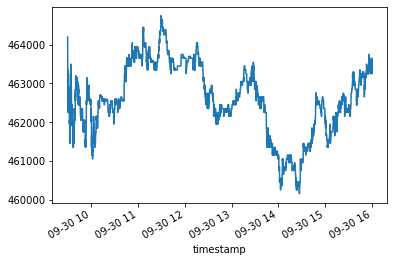

In [42]:
data_path     = "/data/Market"
asset_name    = "MSFT"
trade_date    = '2014-09-30'
tick_size     = 0.001

LOB_data      = get_LOB_data(f'{os.getcwd()}/{data_path}' , asset_name, trade_date)

LOB_features  = get_features(LOB_data,
                                 trade_date = trade_date,
                                 trend      = ({'w' : 25},),
                                 vol        = ({'w' : 500}, {'w' : 1000}, 
                                               {'w' : 5000}, {'w' : 20000}),
                                 depth      = {'w' : 500})
LOB_features.set_index('timestamp').mid_price.plot()

<AxesSubplot:xlabel='timestamp'>

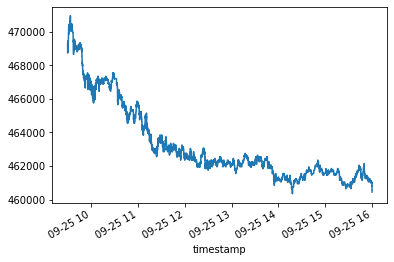

In [47]:
data_path     = "/data/Market"
asset_name    = "MSFT"
trade_date    = '2014-09-25'
tick_size     = 0.001

# 3, 9, 12, 23, 25
LOB_data      = get_LOB_data(f'{os.getcwd()}/{data_path}' , asset_name, trade_date)
LOB_features  = get_features(LOB_data,
                                 trade_date = trade_date,
                                 trend      = ({'w' : 25},),
                                 vol        = ({'w' : 500}, {'w' : 1000}, 
                                               {'w' : 5000}, {'w' : 20000}),
                                 depth      = {'w' : 500})
LOB_features.set_index('timestamp').mid_price.plot()

# Estimate signal dynamics

In [7]:
def estimate_ou_params(feature_data, dn): # dt is in trade time
    y = feature_data.diff(diff_order).iloc[diff_order:] / dt
    x   = sm.add_constant(feature_data).iloc[:-diff_order]
    
    model   = sm.OLS(y.reset_index(drop=True), x.reset_index(drop=True))
    results = model.fit()

    r      = results.params[feature_data.name]
    Ibar   = - results.params['const'] / r
    sigmaI = (results.resid * dt).std() * (1/dt)**0.5
    
    return -r, Ibar, sigmaI

def estimate_ou_params(feature_data, dn): # dt is in trade time
    y = feature_data.shift(-dn).iloc[:-dn].values
    x   = feature_data.iloc[:-dn].values

    model   = sm.OLS(y, x)
    results = model.fit()

    r      = (1-results.params[0])/dn
    sigmaI = results.resid.std() / dn**0.5

    return r, sigmaI, results.rsquared

In [8]:
feature_data              = LOB_features[['imbalance_1', 'imbalance_2', 'timestamp', 'mid_price']]
feature_data.mid_price    = feature_data.mid_price/10000
feature_data              = feature_data.groupby('timestamp').last()

In [21]:

# transform imbalance into prediction : mu_t = 0.033*I_t (for every 0.26 seconds)
# feature_data['I'] = 0.033*(24*60*60/0.26)*feature_data['imbalance_1'] #(6/0.26)

In [22]:
# plt.rcParams['figure.figsize'] = (8., 13. / 16 * 8)
# fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
# feature_data_recent.mid_price.plot(ax=ax1, color='k')
# feature_data_recent.I.plot(ax=ax2, color='k')

In [23]:
# estimate_ou_params(feature_data_recent['imbalance_1'], dn=1)

Text(0.5, 0, 'imbalance')

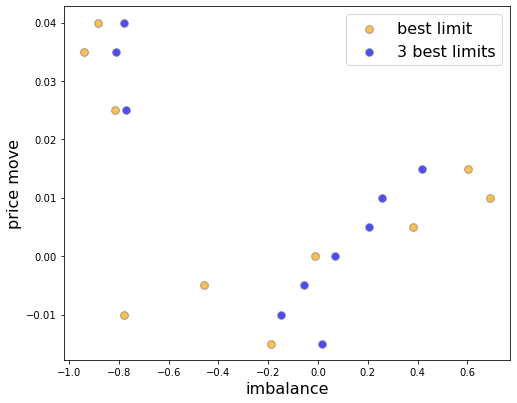

In [9]:
plt.rcParams['figure.figsize'] = (8., 13. / 16 * 8)

feature_data['forward_return'] = feature_data.mid_price.diff(10).shift(-10).round(3)

fig, ax = plt.subplots(1, 1)

ax.scatter(feature_data.groupby('forward_return').mean().imbalance_1,
           feature_data.groupby('forward_return').mean().index,  s=60, alpha=0.7,color='orange', edgecolors="grey")

ax.scatter(feature_data.groupby('forward_return').mean().imbalance_2,
           feature_data.groupby('forward_return').mean().index,  s=60, alpha=0.7,color='blue', edgecolors="grey")

ax.legend(['best limit', '3 best limits'], fontsize=16)
ax.set_ylabel('price move', fontsize=16)
ax.set_xlabel('imbalance', fontsize=16)

# ax.scatter(feature_data.groupby('forward_return').mean().imbalance_1,
#            0.033*feature_data.groupby('forward_return').mean().imbalance_1,  s=60, alpha=0.7, edgecolors="grey")



# Optimal adaptive strategy functions

In [25]:
# thetaI

In [10]:
def v2(t, phi, kappa, alpha, T):
    beta = np.sqrt(phi/kappa)
    xi   = (alpha + np.sqrt(kappa*phi)) / (alpha - np.sqrt(kappa*phi))
    return np.sqrt(kappa*phi) * (1 + xi*np.exp(2*beta*(T-t))) / (1 - xi*np.exp(2*beta*(T-t)))


def getOptimalSpeed(qt, It, ti, ts, T, dt, phi, kappa, alpha, thetaI, sigmaI, v2t):
    t  = ts[ti]
    print('Calling optimalspeed with inventory=', qt, 'and It=', It, 'at t =', t/T)
    optimalspeed = np.sum([ np.exp(-thetaI * (s-t) + np.sum(v2t[ti:si+ti]*dt)/kappa) * dt for (si, s) in enumerate(ts[ti+1:])])
    print(optimalspeed*It)
    print(2*qt)
    print('result = ', -(optimalspeed*It + 2*v2t[ti]*qt)/2/kappa)
    return -(optimalspeed*It + 2*v2t[ti]*qt)/(2*kappa)

In [11]:
tick_size = 0.005
tick_size * 0.1

0.0005

In [12]:
is_os_feature_data_recent    = feature_data.last('2h')
is_feature_data_recent       = is_os_feature_data_recent.first('1h')
is_feature_resampled        = is_feature_data_recent.imbalance_1.resample('10s').mean()
is_price_resampled          = is_feature_data_recent.mid_price.resample('10s').last()


feature_data_recent    = feature_data.last('1h')
feature_resampled      = feature_data_recent.imbalance_1.resample('10s').mean().fillna(method='ffill')
price_resampled        = feature_data_recent.mid_price.resample('10s').last().fillna(method='ffill')

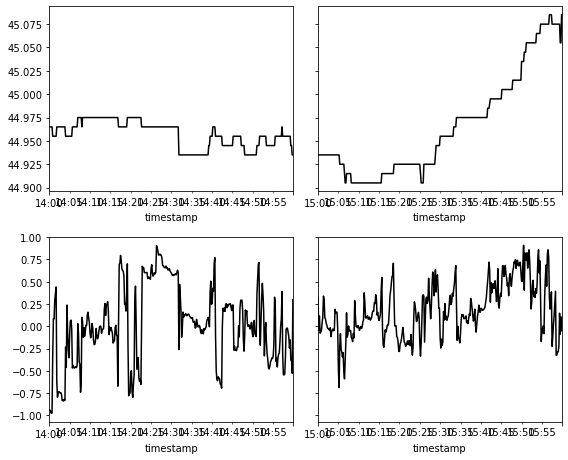

In [13]:
plt.rcParams['figure.figsize'] = (8., 13. / 16 * 8)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.sharey(ax2)
ax3.sharey(ax4)

price_resampled.plot(ax=ax2, color='k')
feature_resampled.plot(ax=ax4, color='k')

is_price_resampled.plot(ax=ax1, color='k')
is_feature_resampled.plot(ax=ax3, color='k')
plt.tight_layout()

In [30]:
# feature_data_recent
# is_feature_resampled

In [31]:
# # estimate kappa
# bid_ask_spread = 0.005
# q0 = 100
# avg_traded_volume_for_wanted_frequency = LOB_features.set_index('timestamp')['traded_volume'].resample('1min').sum().mean()
# participation_rate = 100 /  avg_traded_volume_for_wanted_frequency
# bid_ask_spread / (participation_rate * q0) 

# # kappa * (dqt / dt) * dqt =  participation_rate * bid-ask_spread

In [14]:
estimate_ou_params(is_feature_data_recent.imbalance_1, dn=5)

(0.0049026000398485255, 0.0487610016713194, 0.951910508665795)

In [15]:
# 8/5
estimate_ou_params(feature_data_recent.imbalance_1, dn=5)

(0.006313798998897546, 0.05255772743256229, 0.9378012005850442)

In [22]:
alpha         = 10
phi           = 0.001

# alpha         = 10
# phi           = 0.001
# kappa         = 0.000000025

thetaI, sigmaI,_= estimate_ou_params(is_feature_data_recent.imbalance_1, dn=5)

print('signal dynamics : ', thetaI, sigmaI)

T             = 0.5/24  
dt            = 10/60/60/24
nb_t          = int(T/dt)

kappa         = 1e-7 #0.0000000000025

q0 = 1000

print('trading freq : ', dt, "Test : ", nb_t - len(price_resampled))

ts            = np.linspace(0, T, nb_t+1)
# ts2  = np.linspace(0, T)

v            = np.empty(nb_t)
q            = np.empty(nb_t)
x            = np.empty(nb_t)
pnl          = np.empty(nb_t)
# tradingCosts = np.zeros(nb_t)
phisecs      = np.empty(nb_t)

x[0]         = 0
q[0]         = q0
pnl[0]       = 0
S0           = price_resampled.iloc[0]

print('S0 = ', S0, '. And q0 = ', q0)
print('kappa = ', kappa, '. And phi = ', phi)

signal dynamics :  0.0049026000398485255 0.0487610016713194
trading freq :  0.00011574074074074073 Test :  -180
S0 =  44.935 . And q0 =  1000
kappa =  1e-07 . And phi =  0.001


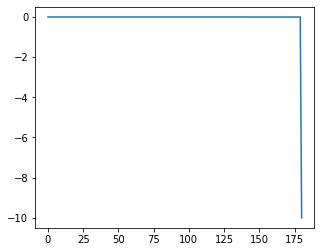

In [23]:
v2t          = np.array([v2(t, phi, kappa, alpha, T) for t in ts])

plt.rcParams['figure.figsize'] = (5., 13. / 16 * 5)
plt.plot(v2t)

In [24]:
for ti in range(nb_t-1):
#     print(q[ti])
#     t             = feature_data_recent.index.values[ti]
    It            = feature_resampled.iloc[ti]
    
    St            = price_resampled.iloc[ti]
    Stp1          = price_resampled.iloc[ti+1]
    
    clear_output(wait=True)
    
    v[ti]         = getOptimalSpeed(qt = q[ti], It = It, ti = ti, ts = ts, T  = T, dt = dt, phi = phi, kappa = kappa, alpha = alpha, thetaI = thetaI, sigmaI=sigmaI, v2t = v2t)
    print('For St = ', round(St,2))
    q[ti+1]       = q[ti] - v[ti]*dt
    
    if np.isnan(q[ti+1]):
        exit()
    x[ti+1]       = x[ti]   + v[ti]*St*dt - kappa*dt*v[ti]**2
    pnl[ti+1]     = x[ti+1] + Stp1 * q[ti+1] - S0 * q[0]

Calling optimalspeed with inventory= 6.572556561772692 and It= 0.2022291109633964 at t = 0.9888888888888888
3.7601702370812574e-05
13.145113123545384
result =  28209.28074620254
For St =  44.94


ValueError: x and y must have same first dimension, but have shapes (360,) and (180,)

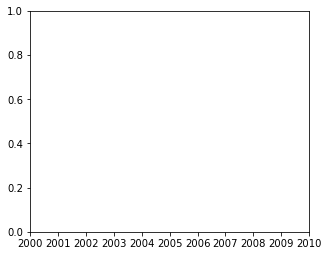

In [25]:
plt.plot(feature_resampled.index, q)
plt.tight_layout()

In [45]:
# q[184]

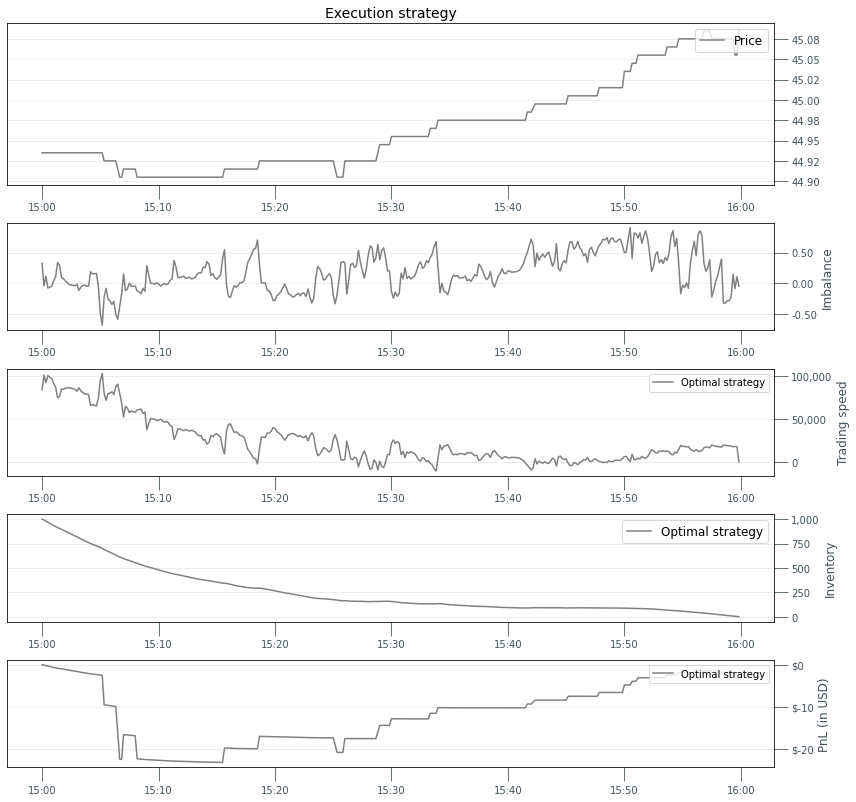

In [21]:
plt.rcParams['figure.figsize'] = (12., 15. / 16 * 12)

fig, axes = plt.subplots(5, 1, gridspec_kw={'height_ratios': [1.5, 1, 1, 1, 1]})

ax1 = axes[0]; ax2 = axes[1]; ax5 = axes[2]; ax3 = axes[3]; ax4 = axes[4]

ax2.sharex(ax1); ax3.sharex(ax1); ax4.sharex(ax1); ax5.sharex(ax1);
ax1.plot(price_resampled.index, price_resampled.values, color= 'grey')
ax2.plot(feature_resampled.index, feature_resampled.values, color= 'grey')
ax5.plot(price_resampled.index, v, color='grey')

ax3.plot(price_resampled.index, q, color='grey')
ax4.plot(price_resampled.index, pnl, color='grey')

ax1.legend(['Price'], loc="upper right", fontsize=12)
ax3.legend(['Optimal strategy'], loc='upper right', fontsize=12)
ax4.legend(['Optimal strategy'], loc='upper right', fontsize=10)
ax5.legend(['Optimal strategy'], loc='upper right', fontsize=10)

ax2.set_ylabel('Imbalance', fontsize=12)
ax3.set_ylabel('Inventory', fontsize=12)
ax4.set_ylabel('PnL (in USD)', fontsize=12)
ax5.set_ylabel('Trading speed', fontsize=12)

for ax in (ax1, ax2, ax5, ax3, ax4):
    ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    ax.yaxis.set_major_formatter(tick2)
    ax.yaxis.tick_right()
    ax.tick_params(axis='both', **config_ticks)
    ax.yaxis.set_label_position("right")
    ax.yaxis.label.set_color(colors['grey'])
    ax.grid(axis='y', color='gainsboro', linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)

ax2.yaxis.set_major_formatter(normal2)
ax1.yaxis.set_major_formatter(normal2)
ax3.yaxis.set_major_formatter(normal)
ax5.yaxis.set_major_formatter(normal)
ax1.set_title(f'Execution strategy', fontsize=14)

plt.tight_layout()
# plt.savefig('backtest_DAI.pdf')
plt.show()

In [53]:
# integrate.quad(lambda t: v2(t, phi, kappa, alpha, T), 0, 10)
# 1/24

# At trade frequency

In [556]:
import scipy.integrate as integrate

def v2(t, phi, kappa, alpha, T):
    beta = np.sqrt(phi/kappa)
    xi   = (alpha + np.sqrt(kappa*phi)) / (alpha - np.sqrt(kappa*phi))
    return np.sqrt(kappa*phi) * (1 + xi*np.exp(2*beta*(T-t))) / (1 - xi*np.exp(2*beta*(T-t)))

def getOptimalSpeed2(qt, It, t, T, phi, kappa, alpha, thetaI, sigmaI):
    int_v2t = lambda s: integrate.quad(lambda t:v2(t, phi, kappa, alpha, T), t, s)[0]
    to_integrate = lambda s: np.exp(-thetaI * (s-t) + int_v2t(s) /kappa)
    optimalspeed = integrate.quad(to_integrate, t, T)[0]
    return -(optimalspeed*It + 2*v2(t, phi, kappa, alpha, T)*qt)/(2*kappa)

In [58]:
is_os_feature_data_recent    = feature_data.last('12min')

is_feature_data_recent    = is_os_feature_data_recent.first('6min')
is_feature_resampled      = is_feature_data_recent.imbalance_1
is_price_resampled        = is_feature_data_recent.mid_price


feature_data_recent    = feature_data.last('6min')
feature_resampled      = feature_data_recent.imbalance_1
price_resampled        = feature_data_recent.mid_price

In [59]:
alpha         = 10
phi           = 0.01
kappa         = 1e-8 #0.0000000000025

thetaI, sigmaI,_= estimate_ou_params(is_feature_data_recent.imbalance_1, dn=5)

print('signal dynamics : ', thetaI, sigmaI)

T             = 6/(60*24)
nb_t          = len(price_resampled)
dt            = T/nb_t
q0            = 100

print('trading freq : ', dt, "T = ",T,"Test : ", nb_t - len(price_resampled))

ts            = np.linspace(0, T, nb_t+1)

v            = np.empty(nb_t)
q            = np.empty(nb_t)
x            = np.empty(nb_t)
pnl          = np.empty(nb_t)

x[0]         = 0
q[0]         = q0
pnl[0]       = 0
S0           = price_resampled.iloc[0]

print('S0 = ', S0, '. And q0 = ', q0)
print('kappa = ', kappa, '. And phi = ', phi)

signal dynamics :  0.0023535897854928935 0.044499018971713544
trading freq :  3.151790216843167e-07 T =  0.004166666666666667 Test :  0
S0 =  45.065 . And q0 =  100
kappa =  1e-08 . And phi =  0.01


In [519]:
allestimations= []
for i in range(5500, len(feature_data), 100):
    allestimations += [estimate_ou_params(feature_data.imbalance_1.iloc[-5500+i:i], dn=5)]
pd.DataFrame(allestimations).describe()

In [ ]:
nb_q_      = 20
nb_I_      = 20
nb_t_      = 10
nb_thetaI_ = 20

All_qs = np.linspace(-100, 100, nb_q_)
All_Is = np.linspace(-1, 1, nb_I_)
All_thetaIs = np.linspace(0.0001, 0.08, nb_thetaI_)


All_ts = list(np.linspace(0, T, nb_t_))
All_ts = All_ts[:-1] + list(np.linspace(All_ts[-2], T, nb_t_))[1:]
All_ts = np.array(All_ts[:-1] + list(np.linspace(All_ts[-2], T, nb_t_))[1:])
nb_t_ = 3 * nb_t_ - 4

optimal_speed_grid = np.zeros((nb_t_, nb_q_, nb_I_, nb_thetaI_))

for qt_ in range(nb_q_):
    print(qt_)
    for It_ in range(nb_I_):
        for tt_ in range(nb_t_):
            for thetaIt_ in range(nb_thetaI_):
                optimal_speed_grid[tt_, qt_, It_, thetaIt_] = \
                                            getOptimalSpeed2(qt  = All_qs[qt_], 
                                                             It  = All_Is[It_], 
                                                             t   = All_ts[tt_], 
                                                             T   = T, 
                                                             phi = phi, 
                                                             kappa  = kappa, 
                                                             alpha  = alpha, 
                                                             thetaI = All_thetaIs[thetaIt_], 
                                                             sigmaI = np.nan)
fn = RegularGridInterpolator( (All_ts, All_qs, All_Is, All_thetaIs), optimal_speed_grid)

In [566]:
((t > All_ts[-2]) | (t < All_ts[0]) | 
        (q[ti] > All_qs[-1]) | (q[ti] < All_qs[0]) |
        (It > All_Is[-1]) | (It < All_Is[0]) | 
        (thetaI > All_thetaIs[-1]) | (thetaI < All_thetaIs[0]))

False

In [567]:
%%time
for ti in range(nb_t-1):
    t  = ts[ti]
    dt = ts[ti+1] - ts[ti]

    It            = feature_resampled.iloc[ti]
    St            = price_resampled.iloc[ti]
    Stp1          = price_resampled.iloc[ti+1]
    
    clear_output(wait=True)
    
#     v[ti]         = getOptimalSpeed2(qt = q[ti], It = It, t = t, T  = T, phi = phi, kappa = kappa, alpha = alpha, thetaI = thetaI, sigmaI=sigmaI)
    if ((t > All_ts[-2]) | (t < All_ts[0]) | 
        (q[ti] > All_qs[-1]) | (q[ti] < All_qs[0]) |
        (It > All_Is[-1]) | (It < All_Is[0]) | 
        (thetaI > All_thetaIs[-1]) | (thetaI < All_thetaIs[0])):
        
        print('FOOOOOOOOOOOOOOOOOOOOOOK')
        v[ti]         = getOptimalSpeed2(qt     = q[ti], 
                                         It     = It, 
                                         t      = t, 
                                         T      = T, 
                                         phi    = phi, 
                                         kappa  = kappa, 
                                         alpha  = alpha, 
                                         thetaI = thetaI, 
                                         sigmaI = sigmaI)
    else:
        v[ti]         = fn((t, q[ti], It, thetaI)) #interpn( (All_qs, All_Is, All_ts), optimal_speed_grid, (q[ti], It, t))[0]

    print('For t = ', round(t,5))
    print('For St = ', round(St,2))
    print('For It = ', round(It,2))
    print('vt = ', round(v[ti],2))
    print('qt = ', round(q[ti],2))
    
    q[ti+1]       = q[ti] - v[ti]*dt
    x[ti+1]       = x[ti]   + v[ti]*St*dt - kappa*dt*v[ti]**2
    pnl[ti+1]     = x[ti+1] + Stp1 * q[ti+1] - S0 * q[0]

FOOOOOOOOOOOOOOOOOOOOOOK
For t =  0.00417
For St =  45.08
For It =  -0.63
vt =  4940.14
qt =  0.0
CPU times: total: 52.1 s
Wall time: 44.4 s


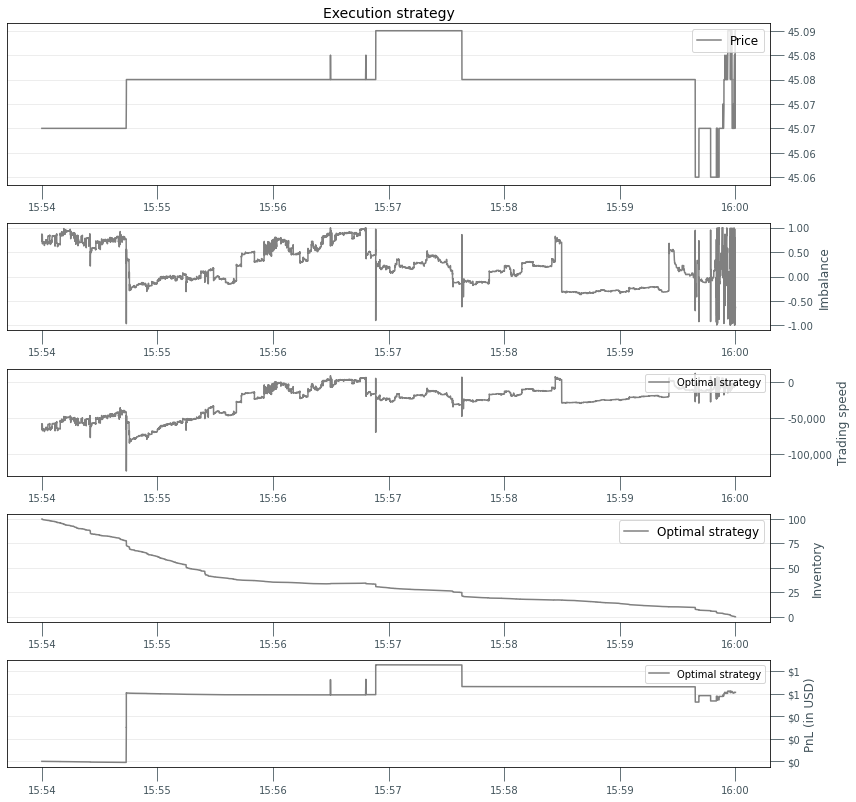

In [568]:
plt.rcParams['figure.figsize'] = (12., 15. / 16 * 12)

fig, axes = plt.subplots(5, 1, gridspec_kw={'height_ratios': [1.5, 1, 1, 1, 1]})

ax1 = axes[0]; ax2 = axes[1]; ax5 = axes[2]; ax3 = axes[3]; ax4 = axes[4]

ax2.sharex(ax1); ax3.sharex(ax1); ax4.sharex(ax1); ax5.sharex(ax1);
ax1.plot(price_resampled.index, price_resampled.values, color= 'grey')
ax2.plot(feature_resampled.index, feature_resampled.values, color= 'grey')
ax5.plot(price_resampled.index, -v, color='grey')

ax3.plot(price_resampled.index, q, color='grey')
ax4.plot(price_resampled.index, pnl, color='grey')

ax1.legend(['Price'], loc="upper right", fontsize=12)
ax3.legend(['Optimal strategy'], loc='upper right', fontsize=12)
ax4.legend(['Optimal strategy'], loc='upper right', fontsize=10)
ax5.legend(['Optimal strategy'], loc='upper right', fontsize=10)

ax2.set_ylabel('Imbalance', fontsize=12)
ax3.set_ylabel('Inventory', fontsize=12)
ax4.set_ylabel('PnL (in USD)', fontsize=12)
ax5.set_ylabel('Trading speed', fontsize=12)

for ax in (ax1, ax2, ax5, ax3, ax4):
    ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    ax.yaxis.set_major_formatter(tick2)
    ax.yaxis.tick_right()
    ax.tick_params(axis='both', **config_ticks)
    ax.yaxis.set_label_position("right")
    ax.yaxis.label.set_color(colors['grey'])
    ax.grid(axis='y', color='gainsboro', linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)

ax2.yaxis.set_major_formatter(normal2)
ax1.yaxis.set_major_formatter(normal2)
ax3.yaxis.set_major_formatter(normal)
ax5.yaxis.set_major_formatter(normal)
ax1.set_title(f'Execution strategy', fontsize=14)

plt.tight_layout()
# plt.savefig('backtest_DAI.pdf')
plt.show()